In [1]:
import sys

sys.path.append('../src')
sys.path.append('../tests')

In [2]:
import os
import gc
import bcolz
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, History
import vgg16
import data_helper
from data_helper import AmazonPreprocessor
# from kaggle_data.downloader import KaggleDataDownloader

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


In [3]:
tf.__version__

'1.15.0'

In [4]:
train_jpeg_dir, test_jpeg_dir, test_jpeg_additional, train_csv_file = data_helper.get_jpeg_data_files_paths()
labels_df = pd.read_csv(train_csv_file)
labels_df.head()



,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [5]:
# Print all unique tags
from itertools import chain
labels_list = list(chain.from_iterable([tags.split(" ") for tags in labels_df['tags'].values]))
labels_set = set(labels_list)
print("There is {} unique labels including {}".format(len(labels_set), labels_set))

There is 17 unique labels including {'selective_logging', 'cloudy', 'slash_burn', 'road', 'artisinal_mine', 'blooming', 'blow_down', 'haze', 'partly_cloudy', 'bare_ground', 'water', 'conventional_mine', 'habitation', 'clear', 'agriculture', 'cultivation', 'primary'}


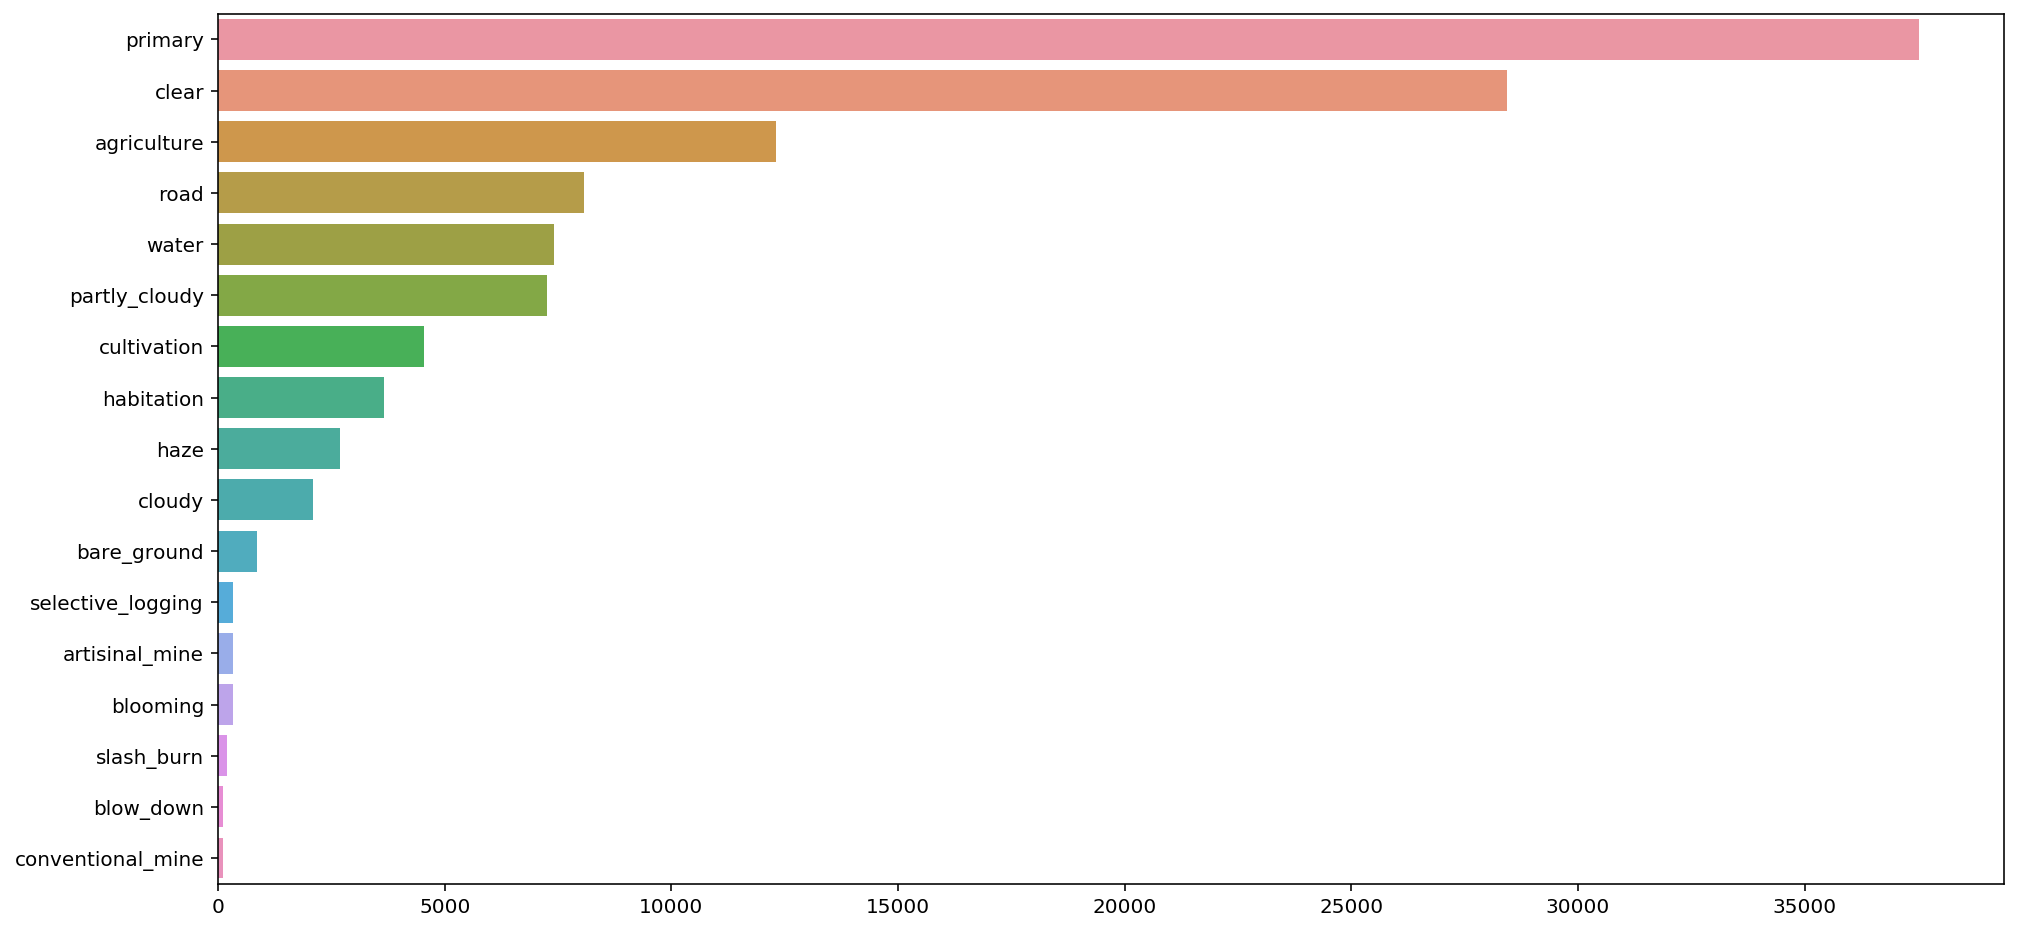

In [6]:
# Histogram of label instances
labels_s = pd.Series(labels_list).value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=labels_s, y=labels_s.index, orient='h')



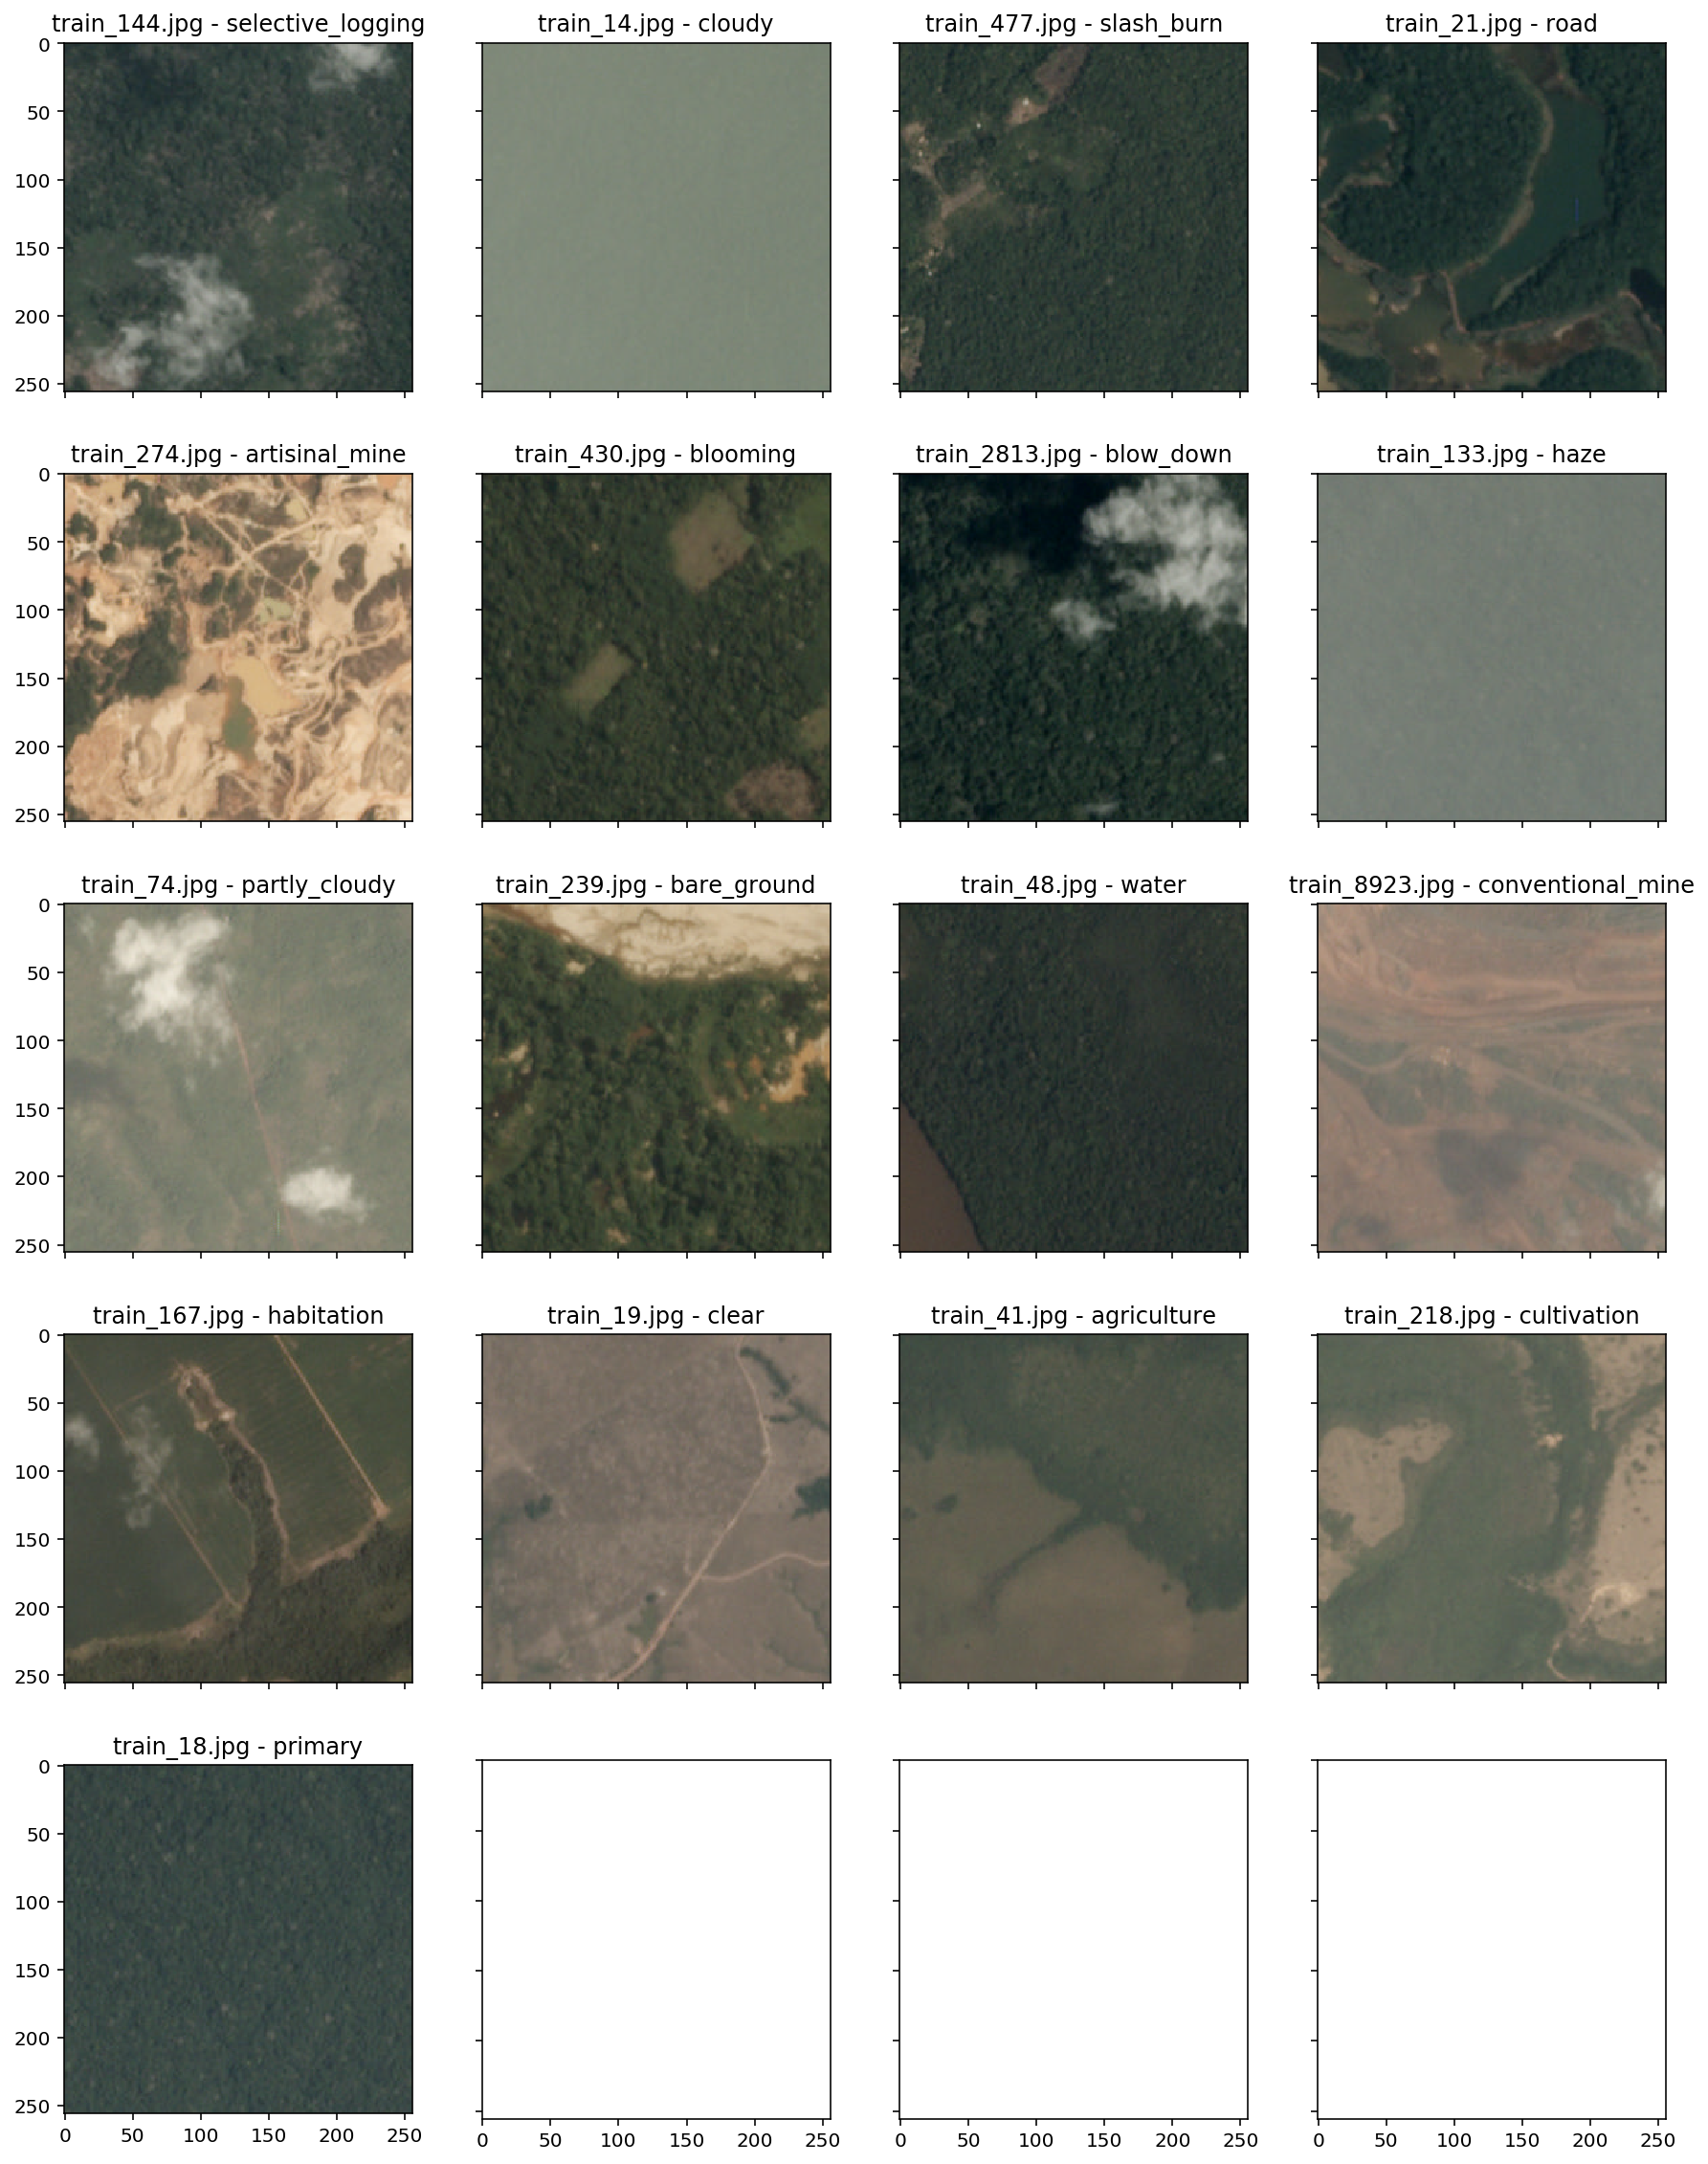

In [7]:
images_title = [labels_df[labels_df['tags'].str.contains(label)].iloc[i]['image_name'] + '.jpg' 
                for i, label in enumerate(labels_set)]

plt.rc('axes', grid=False)
_, axs = plt.subplots(5, 4, sharex='col', sharey='row', figsize=(15, 20))
axs = axs.ravel()

for i, (image_name, label) in enumerate(zip(images_title, labels_set)):
    img = mpimg.imread(train_jpeg_dir + '/' + image_name)
    axs[i].imshow(img)
    axs[i].set_title('{} - {}'.format(image_name, label))

In [8]:
img_resize = (128, 128) # The resize size of each image ex: (64, 64) or None to use the default image size
validation_split_size = 0.2

In [9]:
preprocessor = AmazonPreprocessor(train_jpeg_dir, train_csv_file, test_jpeg_dir, test_jpeg_additional, 
                                  img_resize, validation_split_size)
preprocessor.init()

100%|██████████| 8096/8096 [00:00<00:00, 274205.70it/s]


Transforming val dataset...


100%|██████████| 8096/8096 [00:02<00:00, 3819.92it/s] 


Done. Size consumed by validation matrices 1518.0 mb


In [14]:
from PIL import Image

im = Image.open('test-jpg/test_28297.jpg')
width, height = im.size

In [15]:
width

256

In [16]:
height

256

In [23]:
print("X_train/y_train length: {}/{}".format(len(preprocessor.X_train), len(preprocessor.y_train)))
print("X_val/y_val length: {}/{}".format(len(preprocessor.X_val), len(preprocessor.y_val)))
print("X_test/X_test_filename length: {}/{}".format(len(preprocessor.X_test), len(preprocessor.X_test_filename)))
preprocessor.y_map

X_train/y_train length: 32383/32383
X_val/y_val length: 8096/8096
X_test/X_test_filename length: 61191/61191


{0: 'agriculture',
 1: 'artisinal_mine',
 2: 'bare_ground',
 3: 'blooming',
 4: 'blow_down',
 5: 'clear',
 6: 'cloudy',
 7: 'conventional_mine',
 8: 'cultivation',
 9: 'habitation',
 10: 'haze',
 11: 'partly_cloudy',
 12: 'primary',
 13: 'road',
 14: 'selective_logging',
 15: 'slash_burn',
 16: 'water'}

In [24]:
model = vgg16.create_model(img_dim=(128, 128, 3))
model.summary()





58892288/58889256 [==============================] - 13s 0us/step








_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 3)       12        
_________________________________________________________________
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 17)                139281    
Total params: 14,853,981
Trainable params: 14,853,975
Non-trainable params: 6
_________________________________________________________________


In [26]:


history = History()
callbacks = [history, 
             EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, cooldown=0, min_lr=1e-7, verbose=1),
             ModelCheckpoint(filepath='weights/weights.best.hdf5', verbose=1, save_best_only=True, 
                             save_weights_only=True, mode='auto')]

X_train, y_train = preprocessor.X_train, preprocessor.y_train
X_val, y_val = preprocessor.X_val, preprocessor.y_val

batch_size = 128
train_generator = preprocessor.get_train_generator(batch_size)
steps = len(X_train) / batch_size

model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics = ['accuracy'])
history = model.fit_generator(train_generator, steps, epochs=25, verbose=1, 
                    validation_data=(X_val, y_val), callbacks=callbacks)



Epoch 1/25
253/252 [==============================] - 161s 637ms/step - loss: 0.1033 - acc: 0.9608 - val_loss: 0.0962 - val_acc: 0.9633

Epoch 00001: val_loss improved from inf to 0.09623, saving model to weights/weights.best.hdf5
Epoch 2/25
253/252 [==============================] - 152s 600ms/step - loss: 0.0950 - acc: 0.9637 - val_loss: 0.0943 - val_acc: 0.9640

Epoch 00002: val_loss improved from 0.09623 to 0.09426, saving model to weights/weights.best.hdf5
Epoch 3/25
253/252 [==============================] - 152s 603ms/step - loss: 0.0903 - acc: 0.9655 - val_loss: 0.0910 - val_acc: 0.9652

Epoch 00003: val_loss improved from 0.09426 to 0.09104, saving model to weights/weights.best.hdf5
Epoch 4/25
253/252 [==============================] - 151s 598ms/step - loss: 0.0872 - acc: 0.9666 - val_loss: 0.0902 - val_acc: 0.9659

Epoch 00004: val_loss improved from 0.09104 to 0.09020, saving model to weights/weights.best.hdf5
Epoch 5/25
253/252 [==============================] - 151s 597ms

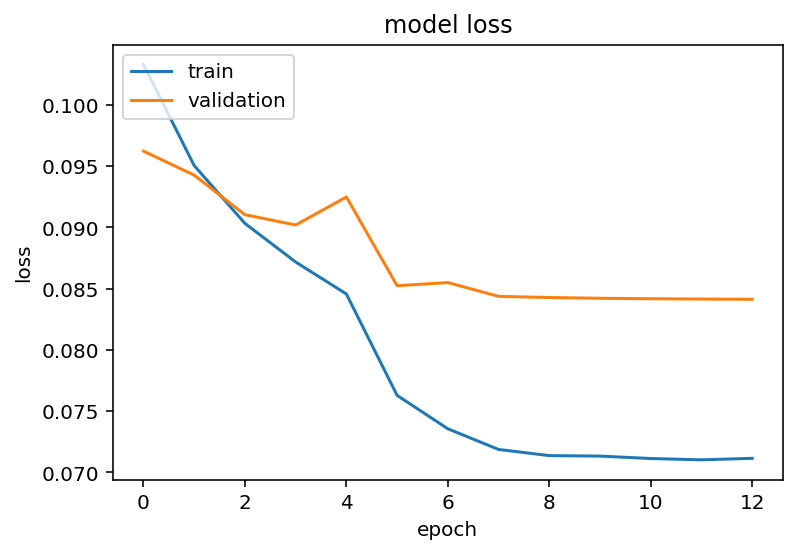

In [27]:


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()



In [28]:
model.load_weights("weights/weights.best.hdf5")
print("Weights loaded")

Weights loaded


In [29]:
fbeta_score = vgg16.fbeta(model, X_val, y_val)

fbeta_score

0.9276997530720504

In [30]:
predictions, x_test_filename = vgg16.predict(model, preprocessor, batch_size=128)
print("Predictions shape: {}\nFiles name shape: {}\n1st predictions ({}) entry:\n{}".format(predictions.shape, 
                                                                              x_test_filename.shape,
                                                                              x_test_filename[0], predictions[0]))

479/478 [==============================] - 279s 583ms/step
Predictions shape: (61191, 17)
Files name shape: (61191,)
1st predictions (test_6921) entry:
[4.6624213e-02 3.4034252e-05 2.2245646e-03 2.6764870e-03 6.7710876e-05
 9.3549740e-01 2.7865171e-05 4.0546060e-04 4.4387281e-03 1.1290729e-02
 3.6826551e-02 7.1252584e-03 9.9964023e-01 9.4312155e-01 1.9908696e-02
 2.2342801e-04 5.1983941e-01]


In [31]:
thresholds = [0.2] * len(labels_set)

In [32]:
predicted_labels = vgg16.map_predictions(preprocessor, predictions, thresholds)

In [33]:
tags_list = [None] * len(predicted_labels)
for i, tags in enumerate(predicted_labels):
    tags_list[i] = ' '.join(map(str, tags))

final_data = [[filename.split(".")[0], tags] for filename, tags in zip(x_test_filename, tags_list)]

In [34]:
final_df = pd.DataFrame(final_data, columns=['image_name', 'tags'])
print("Predictions rows:", final_df.size)
final_df.head()

Predictions rows: 122382


,image_name,tags
0,test_6921,clear primary road water
1,test_21891,agriculture clear habitation haze primary road
2,test_7716,agriculture clear primary
3,test_9946,agriculture clear habitation primary road
4,test_24227,agriculture partly_cloudy primary water


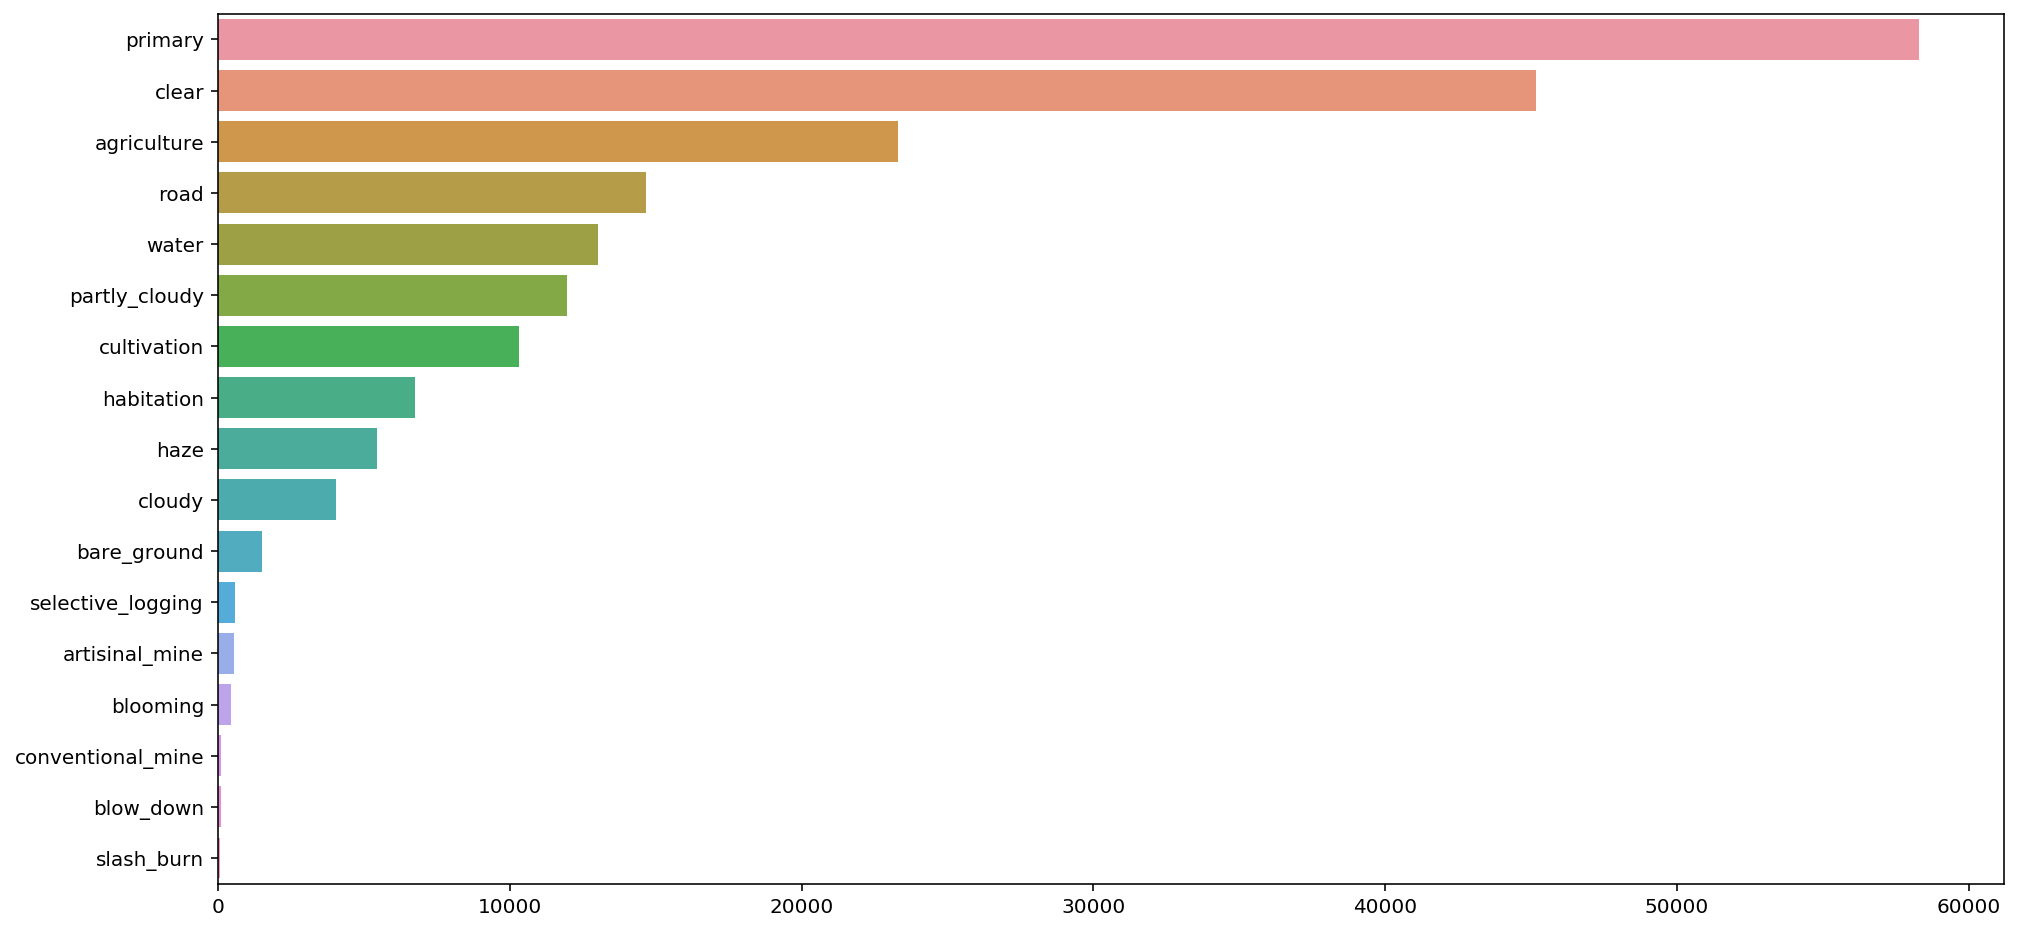

In [35]:
tags_s = pd.Series(list(chain.from_iterable(predicted_labels))).value_counts()
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=tags_s, y=tags_s.index, orient='h');

In [36]:
final_df.to_csv('../submission_file.csv', index=False)